In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider
import plotly.express as px


df = pd.read_csv('eplpass1.csv')



In [34]:
df.columns = df.columns.str.replace('3-Jan', '1/3')  # Fixing the date-like column name
df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores

df['Passes_per_90'] = df['TotCmp'] / df['90s']
df['Long_Pass_%'] = df['LonCmp%']
df['Short_Pass_%'] = df['ShtCmp%']
df['Medium_Pass_%'] = df['MedCmp%']
df['Progressive_Pass_%'] = df['PrgP'] / df['TotCmp'] * 100

print(df.columns.tolist())

['Squad', '#_Pl', '90s', 'TotCmp', 'TotAtt', 'Cmp%', 'TotDist', 'PrgDist', 'ShtCmp', 'ShtAtt', 'ShtCmp%', 'MedCmp', 'MedAtt', 'MedCmp%', 'LonCmp', 'LonAtt', 'LonCmp%', 'Ast', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Poss', 'Touches', 'Def_Pen', 'Def_3rd', 'Mid_3rd', 'Att_3rd', 'Att_Pen', 'Passes_per_90', 'Long_Pass_%', 'Short_Pass_%', 'Medium_Pass_%', 'Progressive_Pass_%']


THE CODE BELOW JUST SHOWS A BASE STACKED BAR GRAPH THAT SHOWS THE THE TOTAL AMOUNT OF COMPLETED PASSES FOR EACH TEAM AND STACKS THE TYPES OF PASSES MADE FOR EACH.

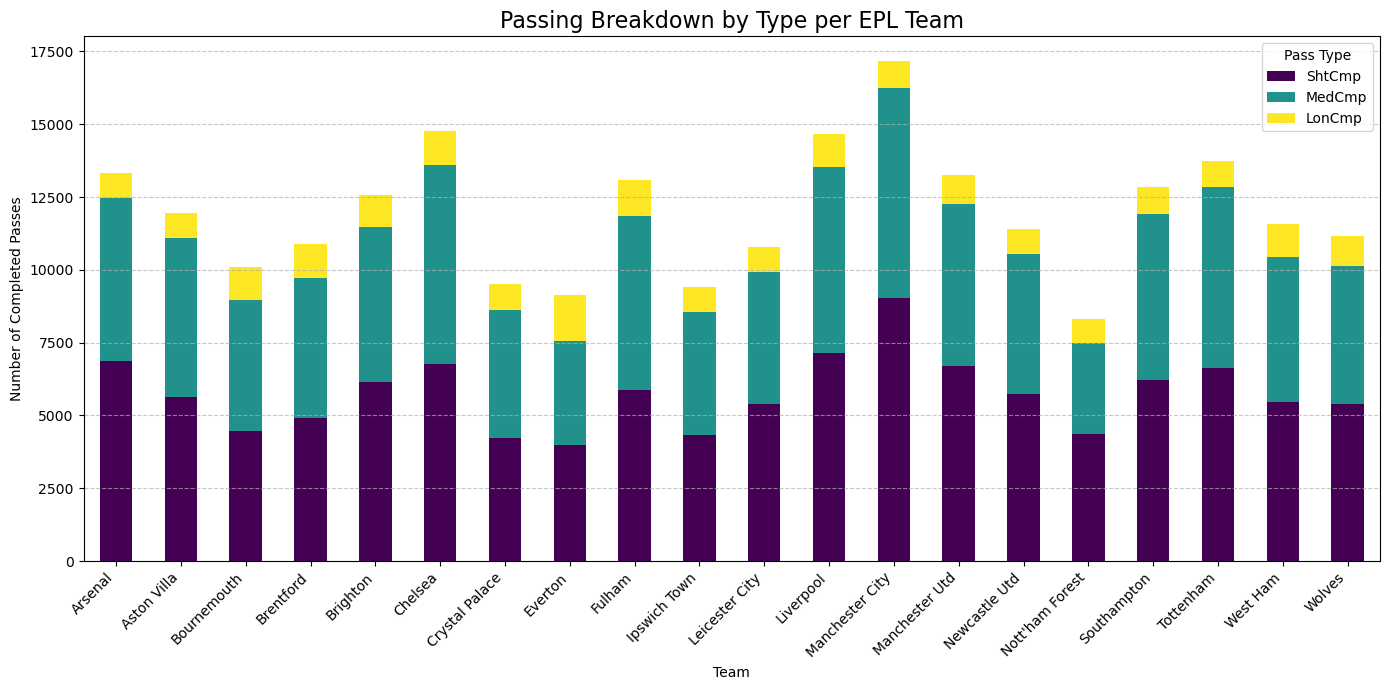

In [35]:
pass_types_df = df[['Squad', 'ShtCmp', 'MedCmp' ,'LonCmp']].set_index('Squad')
ax = pass_types_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Passing Breakdown by Type per EPL Team', fontsize=16)
plt.xlabel('Team')
plt.ylabel('Number of Completed Passes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Pass Type')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

THIS PASS MAP BELOW SHOWS A HEATMAP FOR EACH TEAM DIVIDED INTO THREE PARTS REPRESENTING THE PARTS OF THE PITCH AND THE PERCENTAGES OF DISTRIBUTION GOING ON ON EACH SIDE FOR EACH TEAM.

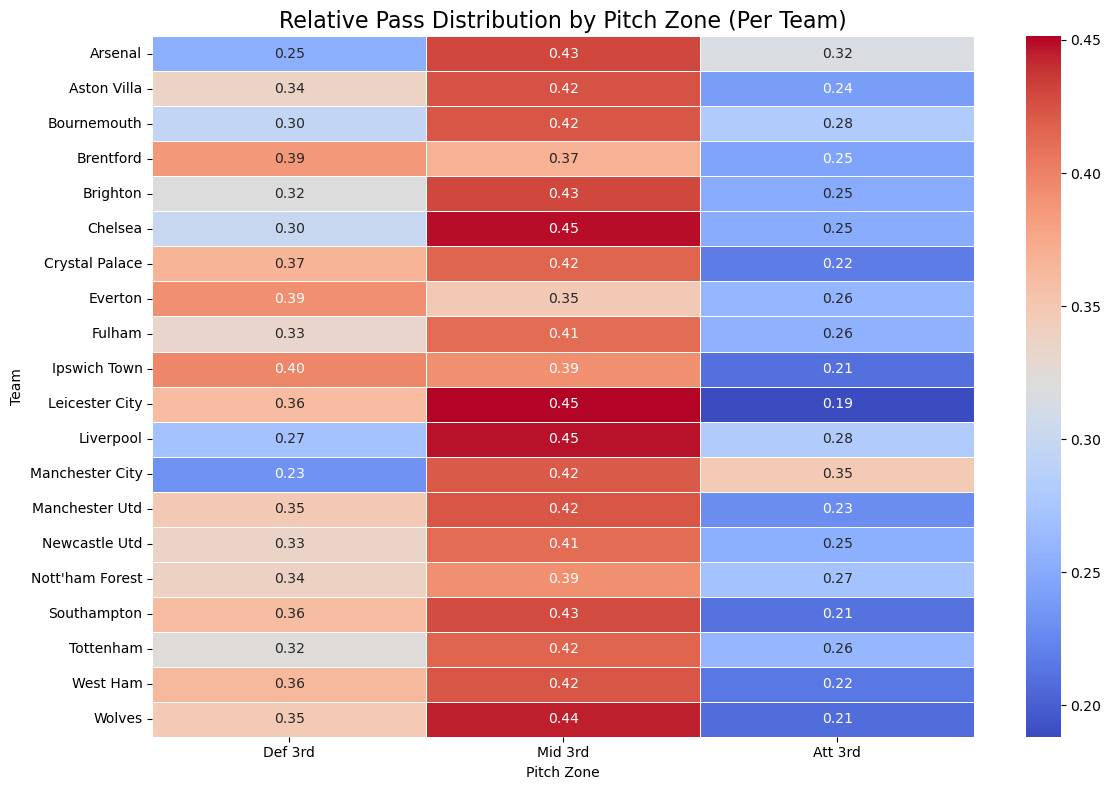

In [15]:
zones_df = df[['Squad', 'Def 3rd', 'Mid 3rd', 'Att 3rd']].set_index('Squad')

zones_normalized = zones_df.div(zones_df.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(zones_normalized, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Relative Pass Distribution by Pitch Zone (Per Team)', fontsize=16)
plt.xlabel('Pitch Zone')
plt.ylabel('Team')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

CREATING A LOT OF SCATTERPLOTS WOULD NOT REALLY HELP MAKE EXPLANATIONS BRIEF SO AN INTERACTIVE ONE WHERE ONE COULD CHOOSE THE CATEGORIES THAT THEY WANT TO BE COMPARED MADE IT MUCH BETTER TO FASTEN INTERACTION

In [36]:
@interact(
    x_axis=Dropdown(options=df.columns, value='Poss', description='X-axis:'),
    y_axis=Dropdown(options=df.columns, value='Cmp%', description='Y-axis:'),
    size_by=Dropdown(options=['TotAtt', 'Ast', 'KP', '90s'], value='TotAtt', description='Bubble Size:')
)
def passing_scatter(x_axis, y_axis, size_by):
    fig = px.scatter(df, x=x_axis, y=y_axis, size=size_by, color='Poss',
                     hover_name='Squad',
                     hover_data=['Cmp%', 'PrgP', 'TotAtt', 'Ast'],
                     title=f"{y_axis} vs {x_axis} | Bubble: {size_by}",
                     color_continuous_scale='Viridis')
    
    fig.add_shape(type='line', x0=df[x_axis].mean(), y0=df[y_axis].min(),
                  x1=df[x_axis].mean(), y1=df[y_axis].max(),
                  line=dict(color='red', width=2, dash='dot'))
    fig.add_shape(type='line', x0=df[x_axis].min(), y0=df[y_axis].mean(),
                  x1=df[x_axis].max(), y1=df[y_axis].mean(),
                  line=dict(color='red', width=2, dash='dot'))
    
    fig.update_layout(width=850, height=550)
    fig.show()


interactive(children=(Dropdown(description='X-axis:', index=23, options=('Squad', '#_Pl', '90s', 'TotCmp', 'To…

BEING ABLE TO CHOOSE THE TEAMS YOU WANT TO COMPARE AS WELL AS COMPARING THEM TO THE LEAGUES AVERAGES WOULD ALSO MAKE THINGS MORE EXPLAINABLE AS IT IS ONE CONTINIUOS CHART THEY LOOK AT. 

In [32]:
from math import pi
from ipywidgets import interact, Dropdown


df = pd.read_csv("eplpass1.csv")
df.columns = df.columns.str.strip()


metrics = {
    'ShortPass%': df['ShtCmp%'],
    'LongPass%': df['LonCmp%'],
    'ProgPass/90': df['PrgP'] / df['90s'],
    'KP/90': df['KP'] / df['90s'],
    'CrossAcc%': (df['CrsPA'] / df['CrsPA'].max()) * 100
}

#for the league averages
league_avg = {k: v.mean() for k, v in metrics.items()}
league_std = {k: v.std() for k, v in metrics.items()}
categories = list(metrics.keys())
N = len(categories)
angles = [n / N * 2 * pi for n in range(N)] + [0]


def interactive_radar(team1, team2):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)

   
    avg_values = [league_avg[k] for k in categories] + [league_avg[categories[0]]]
    ax.plot(angles, avg_values, color='gray', linestyle='--', label='League Average')

 
    def get_team_data(team):
        team_df = df[df['Squad'] == team]
        values = []
        errors = []
        for k in categories:
            val = metrics[k][df['Squad'] == team].values[0]
            values.append(val)
            errors.append(league_std[k] * 0.5)
        return values + [values[0]], errors + [errors[0]]

    # Team 1
    values1, errors1 = get_team_data(team1)
    ax.plot(angles, values1, label=team1, color='blue')
    ax.fill_between(angles, np.array(values1)-np.array(errors1), np.array(values1)+np.array(errors1),
                    alpha=0.2, color='blue')

    # Team 2
    values2, errors2 = get_team_data(team2)
    ax.plot(angles, values2, label=team2, color='orange')
    ax.fill_between(angles, np.array(values2)-np.array(errors2), np.array(values2)+np.array(errors2),
                    alpha=0.2, color='orange')

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_rlabel_position(30)
    plt.yticks(color="grey", size=8)
    plt.ylim(0, max(league_avg.values()) * 1.5)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Passing Style Comparison with Error Margins\n(Shaded areas show variability)', pad=40)
    plt.tight_layout()
    plt.show()


interact(
    interactive_radar,
    team1=Dropdown(options=df['Squad'].unique(), value='Manchester City', description='Team 1'),
    team2=Dropdown(options=df['Squad'].unique(), value='Everton', description='Team 2')
)


interactive(children=(Dropdown(description='Team 1', index=12, options=('Arsenal', 'Aston Villa', 'Bournemouth…

<function __main__.interactive_radar(team1, team2)>